## 추론 기반 기법
- 단어의 출현 확률을 예측하여 빈칸에 들어갈 단어 예측

### 신경망에서의 단어 처리
- 단어를 고정 길이의 벡터로 변환해야 함 (-> one-hot encoding)
- 가중치 벡터와의 곱 (matmul)

### word2vec
- CBOW target & context
- input layer : one-hot encoded context for the target word
- hidden layer : weights that are updated for better results (-> later becomes words' representation)
- output layer : with softmax > percentage for each word

- several input layers share one hidden layer

https://reniew.github.io/21/

In [1]:
import numpy as np

In [2]:
def create_contexts_target(corpus, window_size=1) :
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size) :
        cs = []
        
        for t in range(-window_size, window_size+1) :
            if t == 0 :
                continue
            cs.append(corpus[idx+t])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)

## 학습 단계

#### 1. 단어 id로 변환 contexts & target
#### 2. np.array into one-hot encoded array

In [5]:
from common.layers import MatMul, SoftmaxWithLoss

In [14]:
class SimpleCBOW :
    def __init__(self, vocab_size, hidden_size) :
        V, H = vocab_size, hidden_size
        
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        #layers in side the model
        #in_layer(n) means n input words (same as window size*2)
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        
        self.params, self.grads = [], []
        
        for layer in layers :
            # weights from each layer are saved in self.params list as one element
            # len(self.params) == number of layers
            # same for grads
            self.params += layer.params
            self.grads += layer.grads
            
        self.word_vecs = W_in
        
        print(self.params)
        print(self.grads)
        
    def forward(self, contexts, target) :
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        
        #mean of two hidden layers' output
        h = (h0 + h1) * 0.5
        
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        
        return loss
    
    def backward(self, dout = 1) :
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        
        return None

In [15]:
SimpleCBOW(7, 4)

[array([[-0.00780681,  0.01764484, -0.00167838, -0.00591895],
       [ 0.00191931, -0.00534841,  0.01229863,  0.00376585],
       [ 0.00063682,  0.00680671, -0.00850713,  0.00618001],
       [ 0.0037801 , -0.00031704, -0.00513682,  0.00370572],
       [-0.00256691,  0.0083843 , -0.01803507, -0.00503815],
       [-0.00704925,  0.00289092, -0.00888368, -0.00372187],
       [-0.00198623, -0.01277416,  0.00956557, -0.00398006]],
      dtype=float32), array([[-0.00780681,  0.01764484, -0.00167838, -0.00591895],
       [ 0.00191931, -0.00534841,  0.01229863,  0.00376585],
       [ 0.00063682,  0.00680671, -0.00850713,  0.00618001],
       [ 0.0037801 , -0.00031704, -0.00513682,  0.00370572],
       [-0.00256691,  0.0083843 , -0.01803507, -0.00503815],
       [-0.00704925,  0.00289092, -0.00888368, -0.00372187],
       [-0.00198623, -0.01277416,  0.00956557, -0.00398006]],
      dtype=float32), array([[ 0.02062093,  0.00395792,  0.00998302, -0.01616763,  0.01061388,
        -0.00953501,  0.00

## 학습 코드 구현

[array([[ 0.00196939, -0.00127685,  0.01243406,  0.0026759 , -0.0018962 ],
       [-0.00919872,  0.00250629, -0.01483841,  0.01424812, -0.00754958],
       [-0.00634318, -0.00382559,  0.00611794, -0.00614318,  0.00798347],
       [ 0.03097819, -0.01247904, -0.01285769, -0.0173645 ,  0.01707572],
       [-0.00617169, -0.0044904 , -0.01620629, -0.00741656,  0.00044933],
       [-0.0013871 , -0.01236463, -0.00541185, -0.01220972, -0.01338778]],
      dtype=float32), array([[ 0.00196939, -0.00127685,  0.01243406,  0.0026759 , -0.0018962 ],
       [-0.00919872,  0.00250629, -0.01483841,  0.01424812, -0.00754958],
       [-0.00634318, -0.00382559,  0.00611794, -0.00614318,  0.00798347],
       [ 0.03097819, -0.01247904, -0.01285769, -0.0173645 ,  0.01707572],
       [-0.00617169, -0.0044904 , -0.01620629, -0.00741656,  0.00044933],
       [-0.0013871 , -0.01236463, -0.00541185, -0.01220972, -0.01338778]],
      dtype=float32), array([[ 0.00325414, -0.00357682, -0.00103148, -0.01049678, -0.00

| 에폭 606 |  반복 1 / 1 | 시간 0[s] | 손실 0.77
| 에폭 607 |  반복 1 / 1 | 시간 0[s] | 손실 0.76
| 에폭 608 |  반복 1 / 1 | 시간 0[s] | 손실 0.65
| 에폭 609 |  반복 1 / 1 | 시간 0[s] | 손실 0.88
| 에폭 610 |  반복 1 / 1 | 시간 0[s] | 손실 0.85
| 에폭 611 |  반복 1 / 1 | 시간 0[s] | 손실 0.86
| 에폭 612 |  반복 1 / 1 | 시간 0[s] | 손실 0.86
| 에폭 613 |  반복 1 / 1 | 시간 0[s] | 손실 0.67
| 에폭 614 |  반복 1 / 1 | 시간 0[s] | 손실 0.76
| 에폭 615 |  반복 1 / 1 | 시간 0[s] | 손실 0.85
| 에폭 616 |  반복 1 / 1 | 시간 0[s] | 손실 0.67
| 에폭 617 |  반복 1 / 1 | 시간 0[s] | 손실 0.97
| 에폭 618 |  반복 1 / 1 | 시간 0[s] | 손실 0.77
| 에폭 619 |  반복 1 / 1 | 시간 0[s] | 손실 0.75
| 에폭 620 |  반복 1 / 1 | 시간 0[s] | 손실 0.88
| 에폭 621 |  반복 1 / 1 | 시간 0[s] | 손실 0.97
| 에폭 622 |  반복 1 / 1 | 시간 0[s] | 손실 0.76
| 에폭 623 |  반복 1 / 1 | 시간 0[s] | 손실 0.97
| 에폭 624 |  반복 1 / 1 | 시간 0[s] | 손실 0.75
| 에폭 625 |  반복 1 / 1 | 시간 0[s] | 손실 0.88
| 에폭 626 |  반복 1 / 1 | 시간 0[s] | 손실 0.85
| 에폭 627 |  반복 1 / 1 | 시간 0[s] | 손실 0.63
| 에폭 628 |  반복 1 / 1 | 시간 0[s] | 손실 0.85
| 에폭 629 |  반복 1 / 1 | 시간 0[s] | 손실 0.75
| 에폭 630 |  반복 1

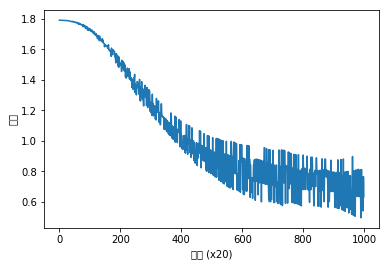

In [16]:
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(text)
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

## CBOW 모델과 확률

- 사후 확률 (Posteriori Probability) : P(A|B)
> probability of A under B

### when it comes to 'word2vec'
- with window_size 1, the posteriori probability(p.p) is like this;
> $$ P(w_t | w_{t+1}, w_{t+1}) $$

### loss function of 'word2vec'
- in cross-entropy loss equation, the probability changes to negative log likelihood of the p.p above

### skip-gram version of 'word2vec'
- skip-gram predicts contexts with target word
> $$ P(w_{t-1}, w_{t+1} | w_t) $$